## Downoload data, import libraries and assign variables

In [17]:
# Dowlnoad dataset from Roboflow 4th version

from roboflow import Roboflow
rf = Roboflow(api_key="jTrkQDoEM9XSpBu2Dm3G")
project = rf.workspace("personal-protective-equipment").project("ppes-kaxsi")
dataset_v_4 = project.version(4).download("yolov8")



loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.134`, to intall it `pip install ultralytics==8.0.134`.



Extracting Dataset Version Zip to PPEs-8 in yolov8:: 100%|██████████| 49860/49860 [00:36<00:00, 1381.65it/s]


In [33]:
# Import libraries
# Setup paths to labels and images

import os
import yaml
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statistics
from collections import Counter
from concurrent.futures import ThreadPoolExecutor
import numpy as np
from PIL import Image


all_labels_paths = ["PPEs-4/train/labels", "PPEs-4/valid/labels"]
all_images_paths = ["PPEs-4/train/images", "PPEs-4/valid/images"]
yaml_file_paths = ["PPEs-4/data.yaml"]


## Class distribution and correlation heatmap

In [28]:
# Pie chart essential functions

# Acumulate the classes names count
def get_classes_names_count(yaml_file_path: str, folder_path: str) -> dict:
    with open(yaml_file_path, 'r') as stream:
        classes_names = yaml.safe_load(stream)['names']
    classes_names_count = {item: 0 for item in classes_names}
    
    # Read the label file and increment the corresponding class name
    def read_label_file(file_path: str, classes_names: list, classes_names_count: dict):
        # Security check if file is a file
        if os.path.isfile(file_path):
            with open(file_path, 'r') as f:
                for line in f:
                    class_name = classes_names[int(line.split()[0])]
                    classes_names_count[class_name] += 1

    # Use multi-threading to read the label file in parallel
    with ThreadPoolExecutor() as executor:
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            future = executor.submit(read_label_file, file_path, classes_names, classes_names_count)
    
    return classes_names_count

def merge_dicts(*dict_args):
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result

# Get the classes names count for each dataset
classes_names_counts = [get_classes_names_count(yaml_file_path, folder_path) for yaml_file_path, folder_path in zip(yaml_file_paths, all_labels_paths)]

# Merge the dictionaries
classes_names_count_all = merge_dicts(*classes_names_counts)

<function stdev_size at 0x000002947A4477E0>


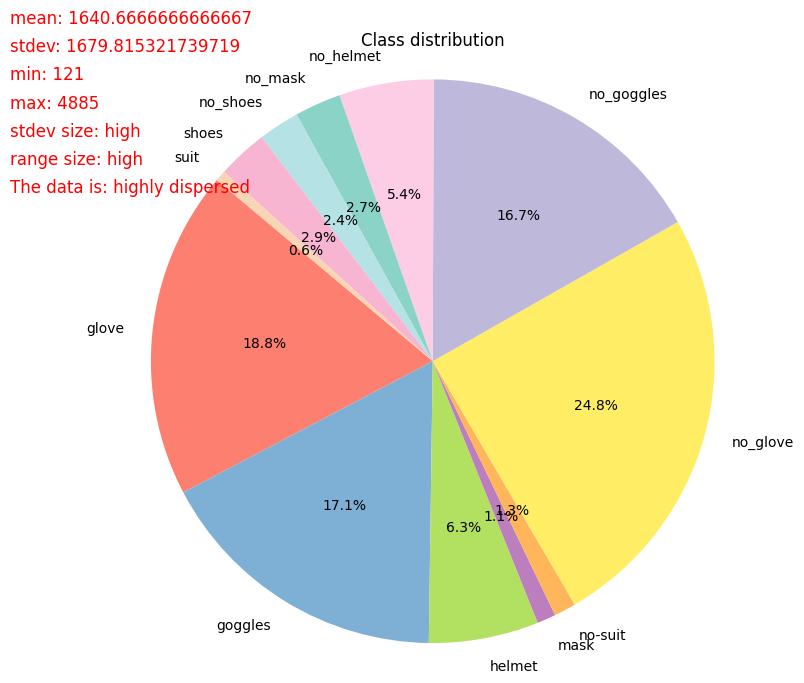

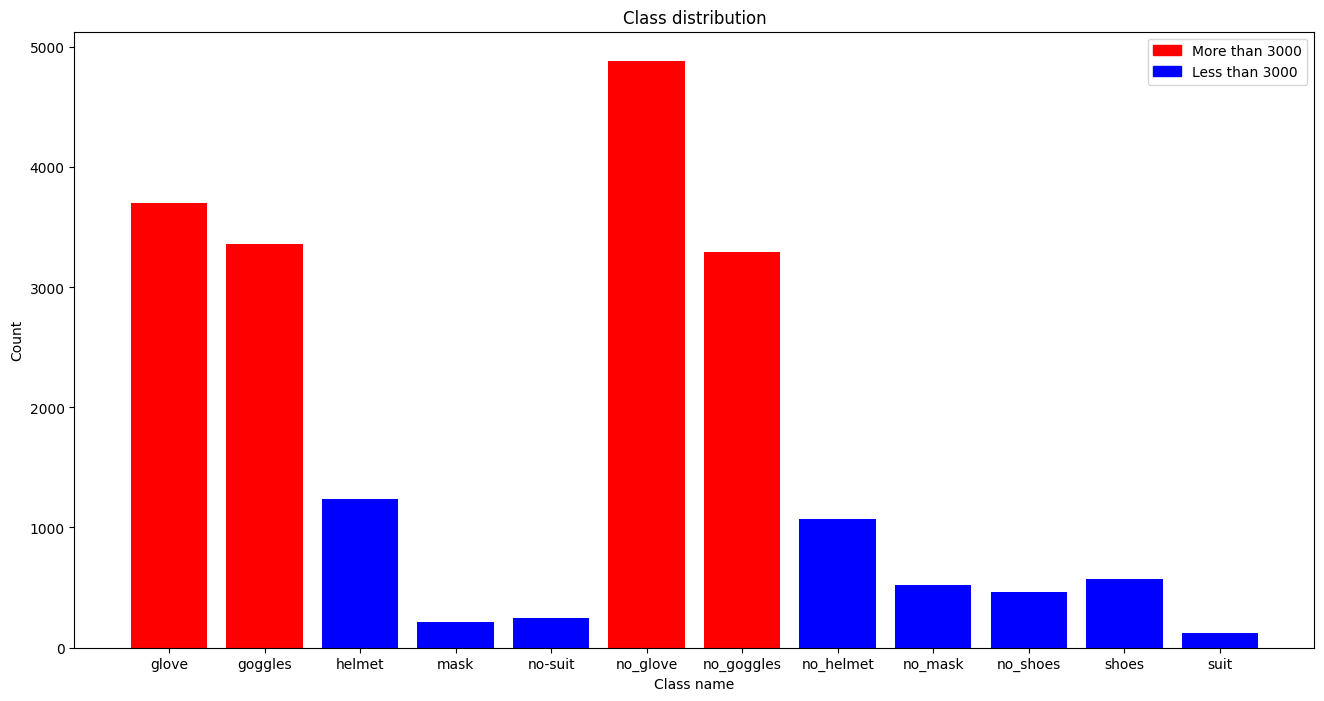

In [34]:
# Analize balance of classes in dataset

# Calculate the standard deviation and coefficient of variation
def stdev_size(data: dict) -> str:
    stdev = statistics.stdev(data)
    mean = statistics.mean(data)
    cv = stdev / mean
    if cv <= 0.33:
        return "low", 0
    elif cv <= 0.66:
        return "medium", 1
    else:
        return "high", 2

# Calculate the range and percentage difference
def range_size(data: dict) -> str:
    range_value = max(data) - min(data)
    percentage_difference = (range_value / max(data)) * 100
    if percentage_difference <= 33:
        return "low", 0
    elif percentage_difference <= 66:
        return "medium", 1
    else:
        return "high", 2

# Calculate the 
def overall_dispersion(data: [int]) -> str:
    #sum the data
    sum = 0
    for i in data:
        sum += i
    if sum <= 0:
        return "no dispersion", 0
    elif sum <= 1:
        return "slightly dispersed", 1
    elif sum <= 2:
        return "moderately dispersed", 2
    else:
        return "highly dispersed", 3
        

# Generate the pie chart with the classes names count and the statistics
def generate_pie_chart(classes_names_count: dict):
    plt.figure(figsize=(8, 8))

    labels = classes_names_count.keys()
    sizes = classes_names_count.values()


    mean = statistics.mean(sizes)
    stdev = statistics.stdev(sizes)
    min_value = min(sizes)
    max_value = max(sizes)
    
    stdev_size_str, stdev_size_value = stdev_size(sizes)
    range_size_str, range_size_value = range_size(sizes)
    overall_dispersion_str, overall_dispersion_value = overall_dispersion([stdev_size_value, range_size_value])
    
    print(stdev_size)

    stats = {
        "mean": mean,
        "stdev": stdev,
        "min": min_value,
        "max": max_value,
        "stdev size": stdev_size_str,
        "range size": range_size_str,
        "The data is": overall_dispersion_str
    }

    colors = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", "#beb9db", "#fdcce5", "#8bd3c7", "#b5e2e5", "#f7b5d1", "#f7d5b5"]



    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title("Class distribution")

    for i, (key, value) in enumerate(stats.items()):
        color = 'green' if overall_dispersion_value == '0' else 'yellow' if overall_dispersion_value == '1' else 'orange' if overall_dispersion_value == '2' else 'red'
        plt.text(-1.5, 1.2 - i * 0.1, f"{key}: {value}", fontsize=12, color=color)


    plt.show()
    
def generate_bar_chart(classes_names_count: dict):
    plt.figure(figsize=(16, 8))

    labels = classes_names_count.keys()
    sizes = classes_names_count.values()

    colors = []
    for size in sizes:
        if size > 3000:
            colors.append('red')
        else:
            colors.append('blue')

    plt.bar(labels, sizes, color=colors)
    plt.title("Class distribution")
    plt.xlabel("Class name")
    plt.ylabel("Count")
    
    # Add legend
    red_patch = mpatches.Patch(color='red', label='More than 3000 images per class')
    blue_patch = mpatches.Patch(color='blue', label='Less than 3000 images per class')
    plt.legend(handles=[red_patch, blue_patch])

    plt.show()

# Generate the pie chart
generate_pie_chart(classes_names_count_all)
generate_bar_chart(classes_names_count_all)

## Image size

In [22]:
# Image size analysis essential functions
def get_image_size(folder_path: str) -> list:
    all_heights_widths = []
    
    def get_image_size(file_path):
        with Image.open(file_path) as img:
            return img.size
    
    with ThreadPoolExecutor() as executor:
        for entry in os.scandir(folder_path):
            if entry.is_file():
                file_path = entry.path
                future = executor.submit(get_image_size, file_path)
                all_heights_widths.append(future.result())
    
    return all_heights_widths


all_heights_widths_all = [size for path in all_images_paths for size in get_image_size(path)]

In [23]:
# Analize the size of images



def get_aspect_ratio(all_heights_widths: list) -> list:
    return [height / width for height, width in all_heights_widths]

def generate_histogram(all_heights_widths: list, data: dict = None):
    
    if type(all_heights_widths[0]) is tuple:
        # Get the heights and widths
        heights = [height for height, width in all_heights_widths]
        widths = [width for height, width in all_heights_widths]
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.hist(heights, bins=20)
        plt.title("Height distribution")
        plt.xlabel("Height")
        plt.ylabel("Frequency")
        plt.subplot(1, 2, 2)
        plt.hist(widths, bins=20)
        plt.title("Width distribution")
        plt.xlabel("Width")
        plt.ylabel("Frequency")
           
        top_4_most_comon = sorted(data.items(), key=lambda x: x[1], reverse=True)[:4]
        
        top_4_most_comon_one_string = "Most common aspect ratios:\n\n"
        
        for i, (key, value) in enumerate(top_4_most_comon):
            top_4_most_comon_one_string += f"ratio: {key}, amount: {value}\n"
        
        plt.text(800, 6000, top_4_most_comon_one_string, fontsize=14)
    
    # Plot the histograms
    plt.show()

def count_all_aspect_ratios_tuples(all_heights_widths: list) -> dict:
    aspect_ratios_tuples = [(height, width) for height, width in all_heights_widths]
    return Counter(aspect_ratios_tuples)





generate_histogram(all_heights_widths_all, count_all_aspect_ratios_tuples(all_heights_widths_all))


ValueError: Image size of 148703x547 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1200x600 with 2 Axes>

## Bounding boxes number an distribution

In [24]:
# get bounding boxes properties an count essential functions

def get_bounding_boxes_count_and_properties(folders_path: list) -> list:
    all_bounding_boxes_count = []
    all_bounding_boxes_properties = []

    def get_bounding_boxes_count(file_path):
        with open(file_path, 'r') as f:
            return len(f.readlines())

    def get_bounding_boxes_properties(file_path):
        properties = []
        with open(file_path, 'r') as f:
            for line in f:
                class_index, x_center, y_center, width, height = line.split()
                properties.extend([float(x_center), float(y_center), float(width), float(height)])
                if len(properties) == 4:
                    all_bounding_boxes_properties.append(properties)
                    properties = []
        return properties

    with ThreadPoolExecutor() as executor:
        for folder_path in folders_path:
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                future = executor.submit(get_bounding_boxes_count, file_path)
                all_bounding_boxes_count.append(future.result())
                future = executor.submit(get_bounding_boxes_properties, file_path)
                all_bounding_boxes_properties.extend(future.result())

    return all_bounding_boxes_count, all_bounding_boxes_properties



all_bounding_boxes_count, all_bounding_boxes_properties = get_bounding_boxes_count_and_properties(all_labels_paths)

### Bounding boxes number

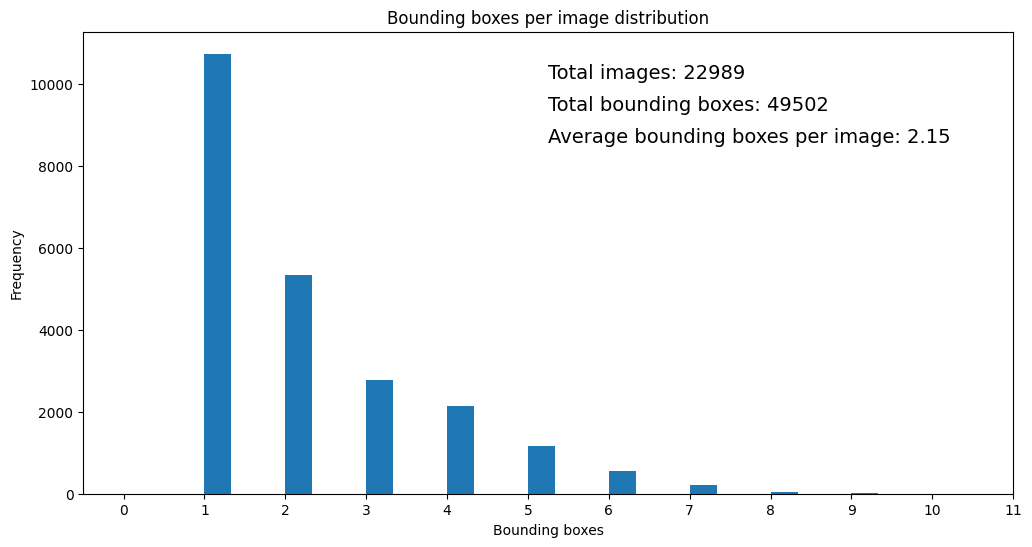

In [25]:
# Analize count of bounding boxes per image


# Get number of all bounding boxes
def get_bounding_boxes_count(folder_path: str) -> list:
    all_bounding_boxes_count = []
    
    def get_bounding_boxes_count(file_path):
        with open(file_path, 'r') as f:
            return len(f.readlines())
    
    with ThreadPoolExecutor() as executor:
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            future = executor.submit(get_bounding_boxes_count, file_path)
            all_bounding_boxes_count.append(future.result())
    
    return all_bounding_boxes_count

# Get number of all images
def get_image_count(folder_path: str) -> int:
    return len(os.listdir(folder_path))

def generate_histogram(all_bounding_boxes_count: list, all_images_count: int, average_bounding_boxes_per_image: float, total_bounding_boxes: int):
    
    total_bounding_boxes = sum(all_bounding_boxes_count)
    average_bounding_boxes_per_image = total_bounding_boxes / all_images_count
    
    plt.figure(figsize=(12, 6))
    n, bins, patches = plt.hist(all_bounding_boxes_count, bins=30)
    plt.title("Bounding boxes per image distribution")
    plt.xlabel("Bounding boxes")
    plt.ylabel("Frequency")
    plt.xticks(range(0, 12, 1))
    plt.text(0.5, 0.9, f"Total images: {all_images_count}", transform=plt.gca().transAxes, fontsize=14)
    plt.text(0.5, 0.83, f"Total bounding boxes: {total_bounding_boxes}", transform=plt.gca().transAxes, fontsize=14)
    plt.text(0.5, 0.76, f"Average bounding boxes per image: {average_bounding_boxes_per_image:.2f}", transform=plt.gca().transAxes, fontsize=14)
    plt.show()


all_images_count = sum([get_image_count(path) for path in all_images_paths])

generate_histogram(all_bounding_boxes_count, all_images_count, sum(all_bounding_boxes_count) / all_images_count, sum(all_bounding_boxes_count))

### Bounding boxes distribution

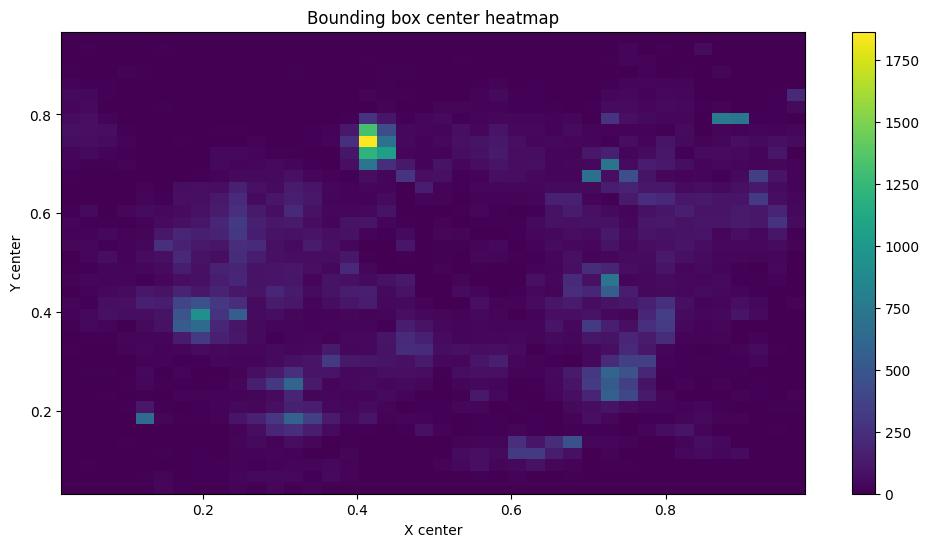

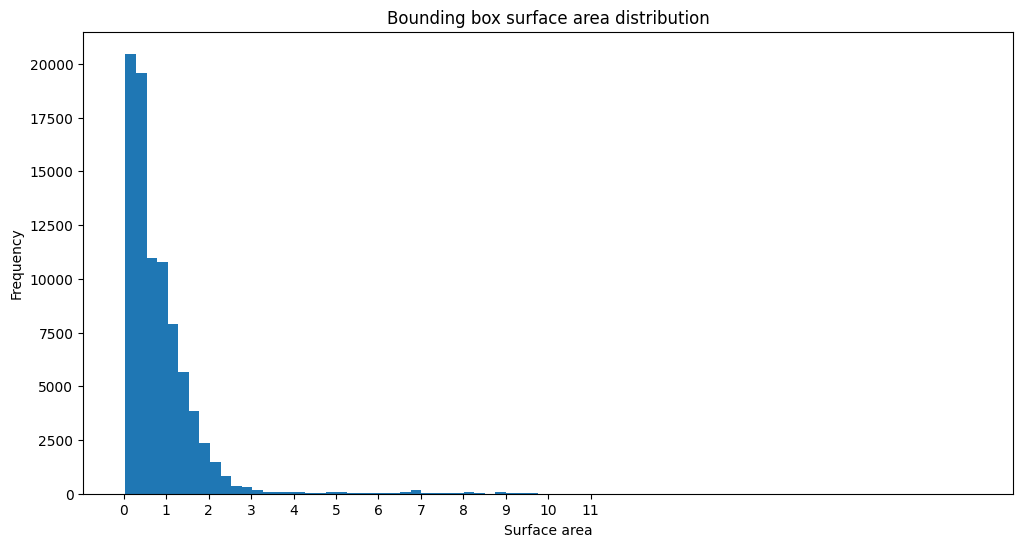

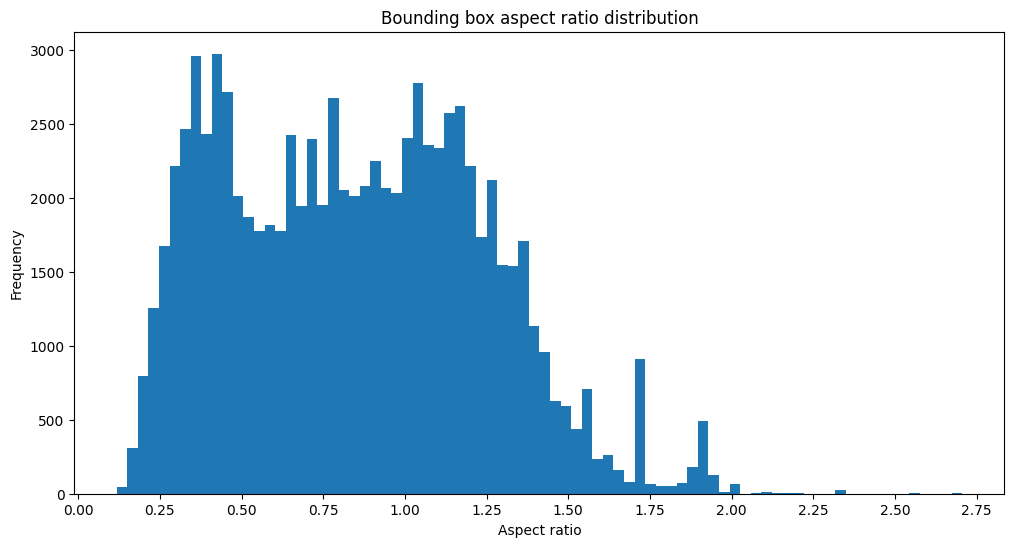

In [10]:
# Analize the properties of bounding boxes


# Get the properties of the bounding boxes
def get_bounding_boxes_properties(folder_path: str) -> list:
    all_bounding_boxes_properties = []
    
    def get_bounding_boxes_properties(file_path):
        with open(file_path, 'r') as f:
            for line in f:
                class_index, x_center, y_center, width, height = line.split()
                all_bounding_boxes_properties.append([float(x_center), float(y_center), float(width), float(height)])
    
    with ThreadPoolExecutor() as executor:
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            future = executor.submit(get_bounding_boxes_properties, file_path)
    
    return all_bounding_boxes_properties

def generate_heatmap(all_bounding_boxes_properties: list):
    # Get the properties of the bounding boxes
    
    x_centers = [x_center for x_center, y_center, width, height in all_bounding_boxes_properties]
    y_centers = [y_center for x_center, y_center, width, height in all_bounding_boxes_properties]
    
    # Plot the heatmaps
    plt.figure(figsize=(12, 6))
    plt.hist2d(x_centers, y_centers, bins=40)
    plt.title("Bounding box center heatmap")
    plt.xlabel("X center")
    plt.ylabel("Y center")
    plt.colorbar()
    plt.show()

def get_surface_area(data: list) -> list:
    surface_areas = []
    for x_center, y_center, width, height in data:
        surface_areas.append(width * height * 100)
    return surface_areas

def get_aspect_ratio(data: list) -> list:
    aspect_ratios = []
    for x_center, y_center, width, height in data:
        aspect_ratios.append(width / height)
    return aspect_ratios


def generate_histogram(data: list, title: str, x_label: str, y_label: str, min : float = 0, max : float = 12, step : float = 1):
    plt.figure(figsize=(12, 6))
    plt.hist(data, bins=80)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(np.arange(min, max, step))
    plt.show()


generate_heatmap(all_bounding_boxes_properties)
generate_histogram(get_surface_area(all_bounding_boxes_properties), "Bounding box surface area distribution", "Surface area", "Frequency")
generate_histogram(get_aspect_ratio(all_bounding_boxes_properties), "Bounding box aspect ratio distribution", "Aspect ratio", "Frequency", 0, 3, 0.25)

## Empty label files

In [13]:
# Analize the empty files

def empty_files_percentage(folder_paths: list) -> float:
    empty_files = 0
    total_files = 0
    for folder_path in folder_paths:
        for filename in os.listdir(folder_path):
            total_files += 1
            file_path = os.path.join(folder_path, filename)
            if os.stat(file_path).st_size == 0:
                empty_files += 1
    return empty_files / total_files * 100

empty_files = empty_files_percentage(all_labels_paths)

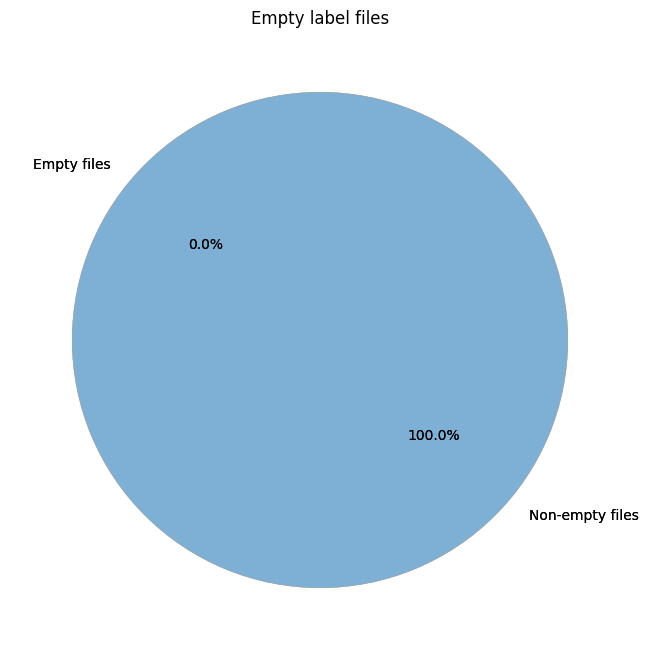

In [14]:
# Generate the pie chart

def generate_pie_chart(labels: list, sizes: list, title: str):
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title(title)
    colors = ["#fd7f6f", "#7eb0d5"]
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.show()



generate_pie_chart(["Empty files", "Non-empty files"], [empty_files, 100 - empty_files], "Empty label files")


In [ ]:

#TODO - how many photos per class
#TODO - how many bounding boxes per class
#TODO - how many bounding boxes per class per photo
#TODO - how many bounding boxes per photo
#TODO - how many of each class per photo
#TODO - how many various class per photo
#TODO - how many photos are made by CCTV
#TODO - how many photos are similar to other photos
#TODO - how many photos are similar to other photos in other datasets 

#TODO - how many labels are empty